# DL-TDDFT Test

## DL-$h_{eff}(t)$ mapping test $h(t) \rightarrow h_{eff}(t)$

### Test the prediction of the model

#### Imports

In [2]:
import torch
import numpy as np
from numpy.fft import fft,ifft
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
from typing import List


In [3]:
data=np.load('data/dataset_h_eff/train_dataset_fourier_format_240301_ndata_60000.npz')

h=data['h']
potential=data['potential']

new_h=h[:,:,:101]
new_potential=potential[:,:,:101]

np.savez('data/dataset_h_eff/train_dataset_fourier_format_half_spectrum_ndata_60000.npz',h=new_h,potential=new_potential)



#### Parameters

In [4]:
data_fourier=np.load('data/dataset_h_eff/train_dataset_fourier_format_240229_ndata_20000.npz')

nbatch=100

h_fft=data_fourier['h']
h_eff_fft=data_fourier['potential']

h_fft_torch=torch.tensor(h_fft[:nbatch,:,:101])

model=torch.load('model_rep/kohm_sham/cnn_field2field/REDENT2D_fourier_field2field_time_steps_200_tf_20_240327_dataset_60k_[80, 80, 80]_hc_[15, 5]_ks_1_ps_3_nconv_1_nblock',map_location='cpu')
model.eval()



REDENT2D(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv2d(2, 80, kernel_size=(15, 5), stride=(1, 1), padding=(7, 2), padding_mode=circular)
      (batch_norm 1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation 1): GELU(approximate='none')
      (conv_1_1): Conv2d(80, 80, kernel_size=(15, 5), stride=(1, 1), padding=(7, 2), padding_mode=circular)
      (batch_norm 1_1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_1_1): GELU(approximate='none')
      (pooling 1): AvgPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0)
    )
    (1): Sequential(
      (conv2): Conv2d(80, 80, kernel_size=(15, 5), stride=(1, 1), padding=(7, 2), padding_mode=circular)
      (activation 2): GELU(approximate='none')
      (conv_2_1): Conv2d(80, 80, kernel_size=(15, 5), stride=(1, 1), padding=(7, 2), padding_mode=circular)
      (activation_2_1): GELU(approximate='none')
      (pool

In [5]:
output=model(h_fft_torch).detach().numpy()

symmetric_part=np.flip(output[:,:,1:-1],axis=-2)

h_eff_fft_reconstruction=np.append(output,symmetric_part,axis=-2)
print(h_eff_fft_reconstruction.shape)

h_eff_fft_reconstruction[:,1,100:]=-1*h_eff_fft_reconstruction[:,1,100:]


(100, 2, 200, 8)


#### Test in the fourier space

(20000, 2, 200, 8)


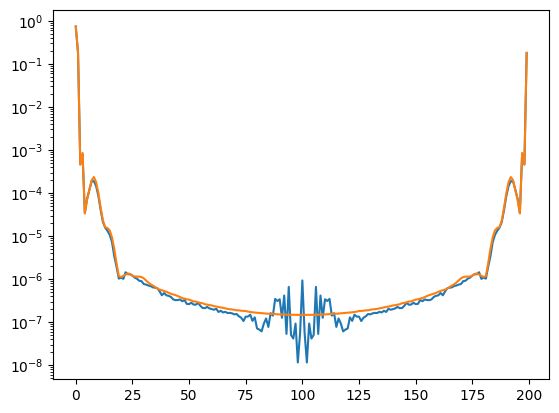

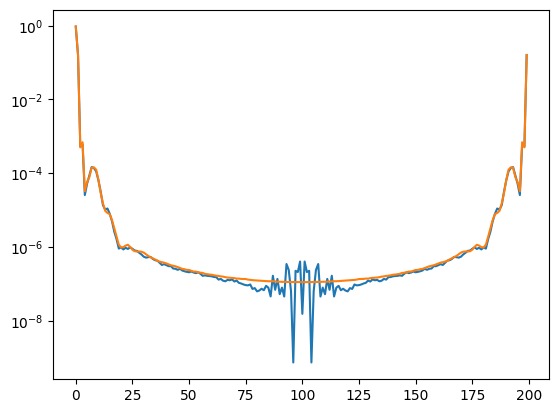

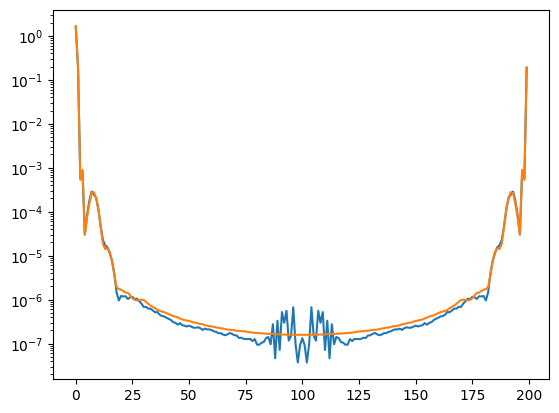

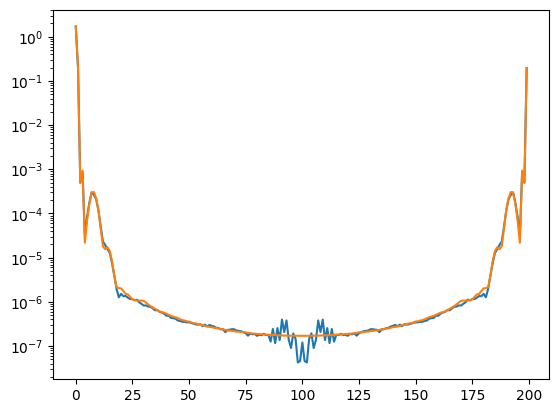

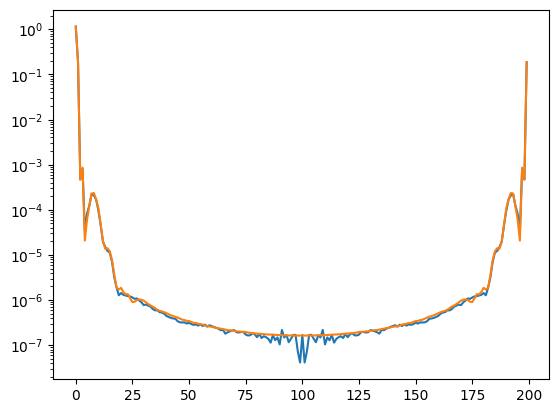

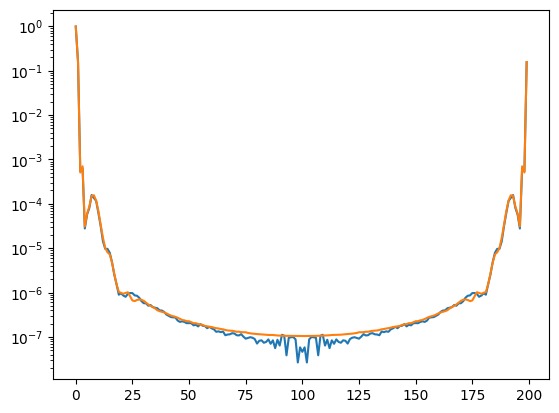

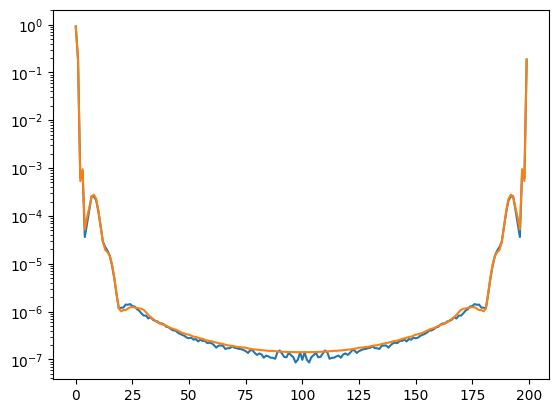

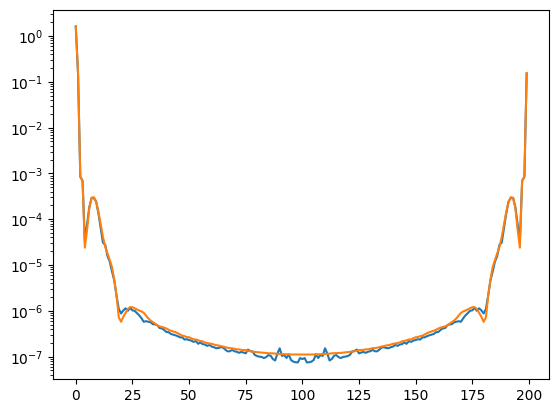

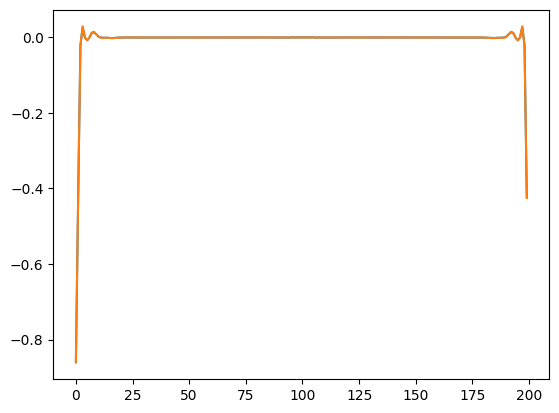

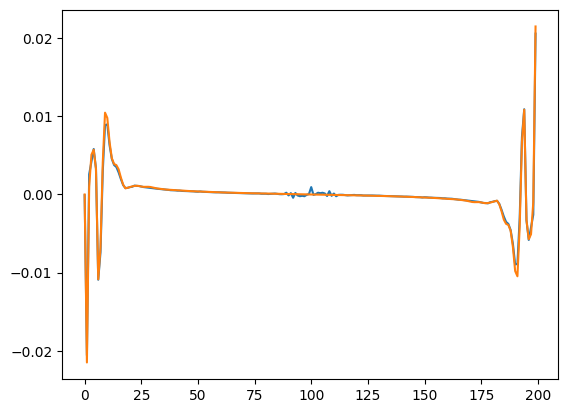

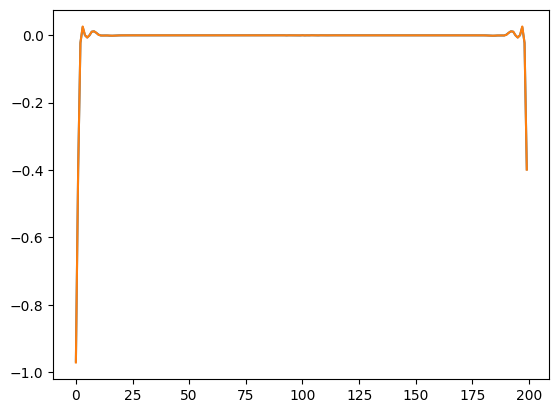

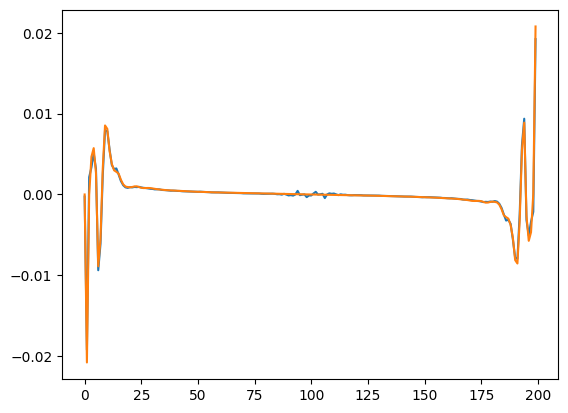

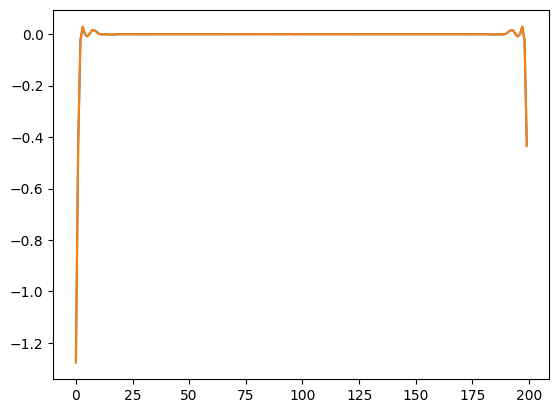

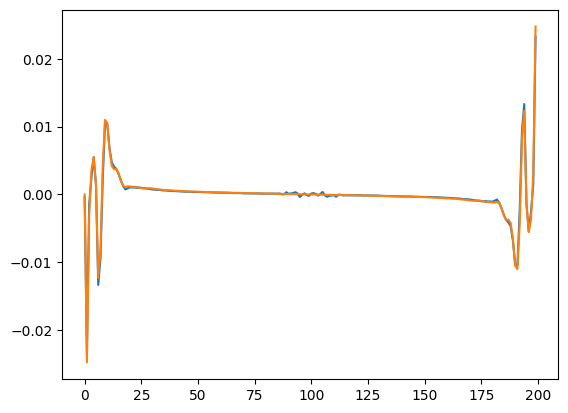

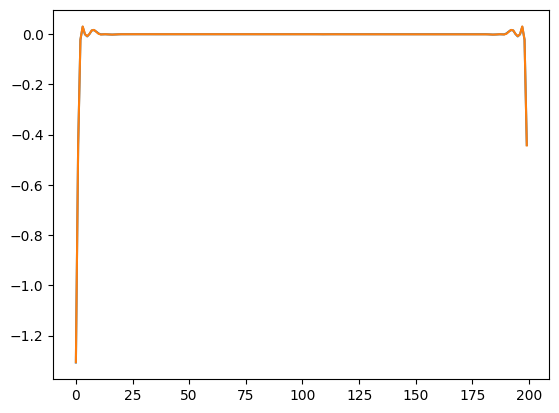

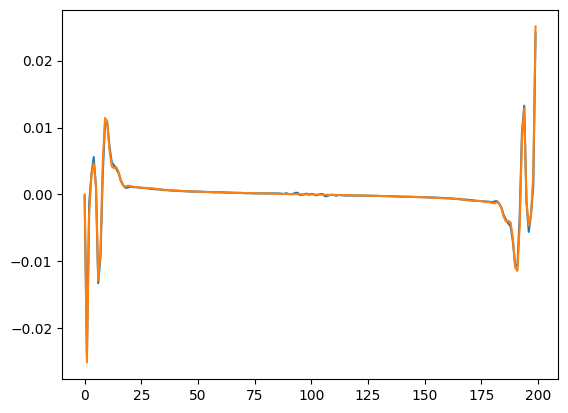

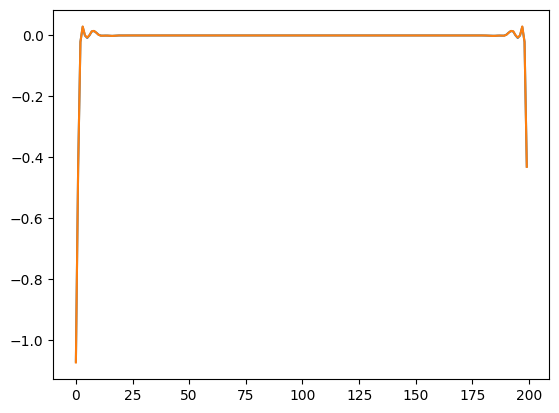

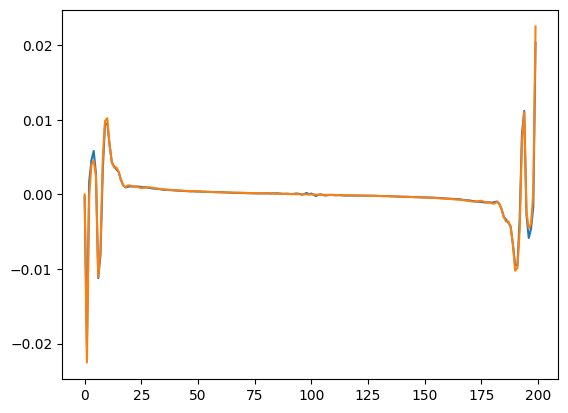

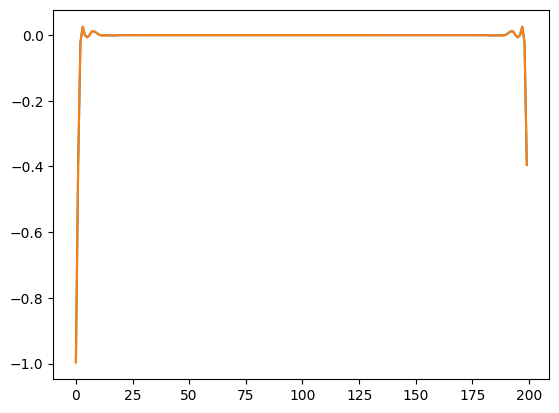

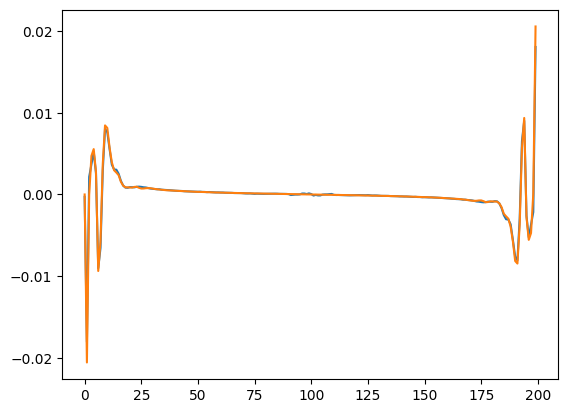

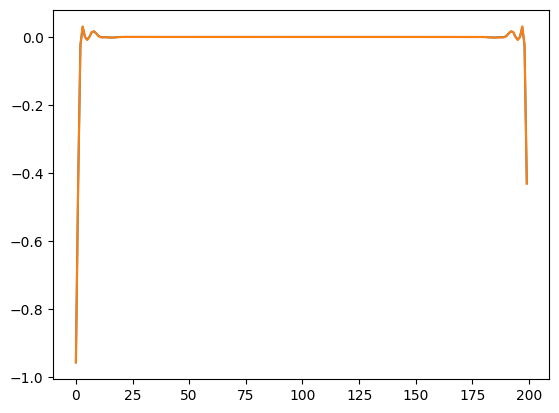

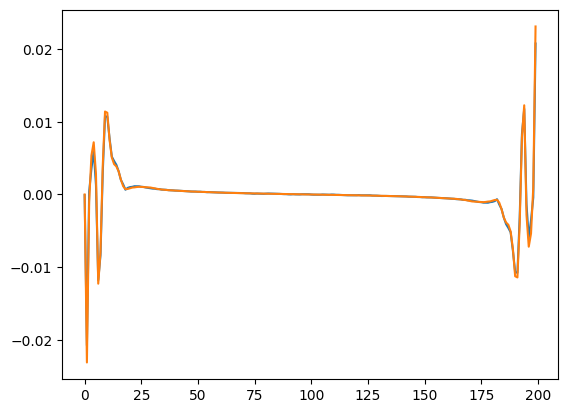

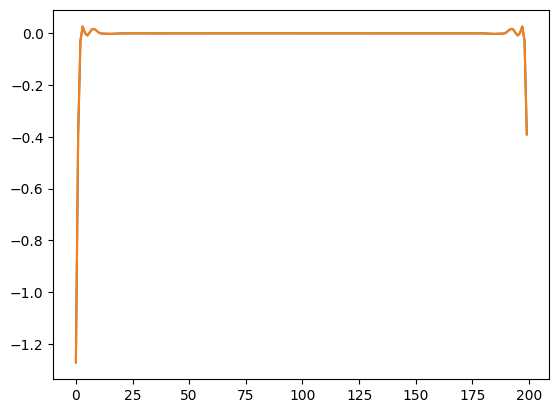

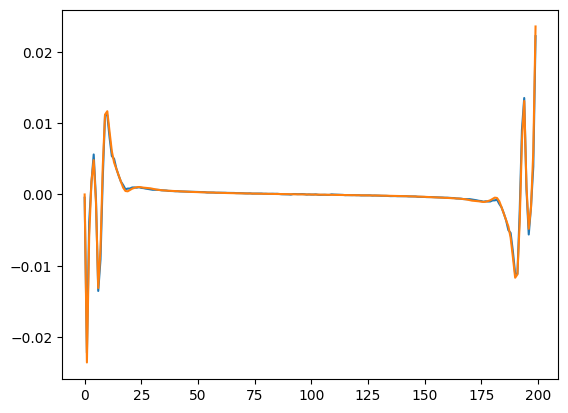

In [6]:
idx=np.random.randint(0,nbatch)
print(h_eff_fft.shape)
for i in range(h_eff_fft.shape[-1]):
    
    plt.plot(h_eff_fft_reconstruction[idx,0,:,i]**2+h_eff_fft_reconstruction[idx,1,:,i]**2)
    plt.plot(h_eff_fft[idx,0,:,i]**2+h_eff_fft[idx,1,:,i]**2)
    plt.semilogy()
    plt.show()
    
for i in range(h_eff_fft.shape[-1]):
    
    plt.plot(h_eff_fft_reconstruction[idx,0,:,i])
    plt.plot(h_eff_fft[idx,0,:,i])
    plt.show()

    plt.plot(h_eff_fft_reconstruction[idx,1,:,i])
    plt.plot(h_eff_fft[idx,1,:,i])
    plt.show()



#### (Optional) Fourier filter

In [13]:
h_eff_fft_reconstruction_filter=h_eff_fft_reconstruction.copy()
h_eff_fft_reconstruction_filter[:,:,40:-40]=0.
h_eff_reconstruction_filter=ifft(h_eff_fft_reconstruction_filter[:,0]+1j*h_eff_fft_reconstruction_filter[:,1],norm='forward',axis=1)


#### Test in the time space

/home/ecosta/miniconda3/envs/dft_env/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ecosta/miniconda3/envs/dft_env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


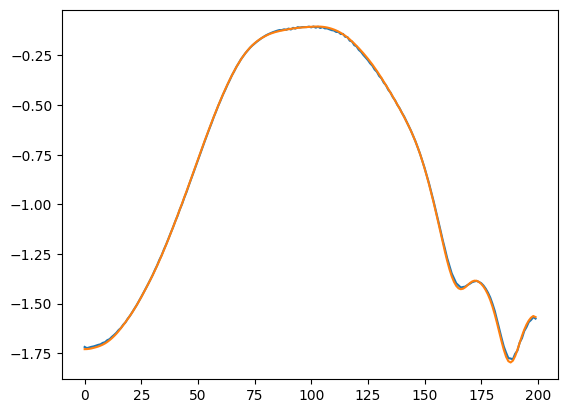

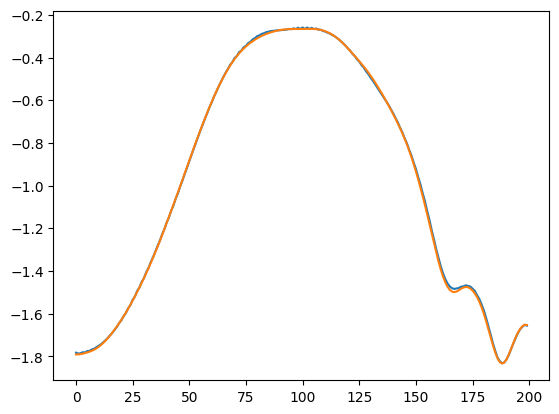

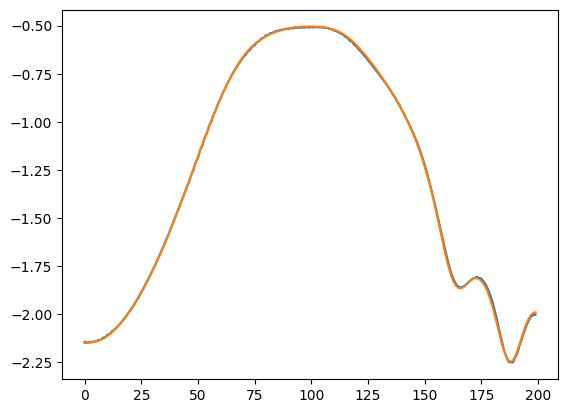

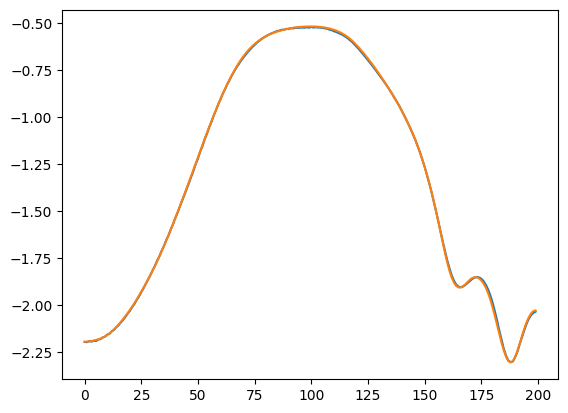

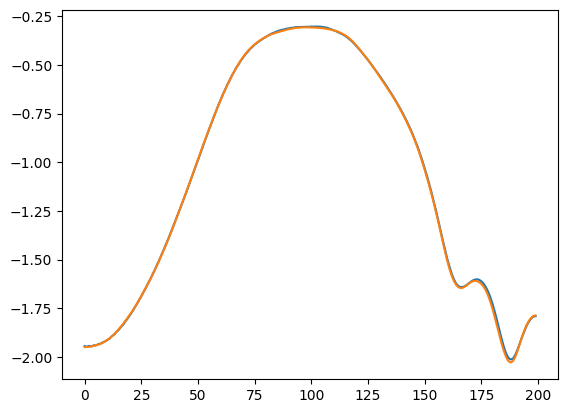

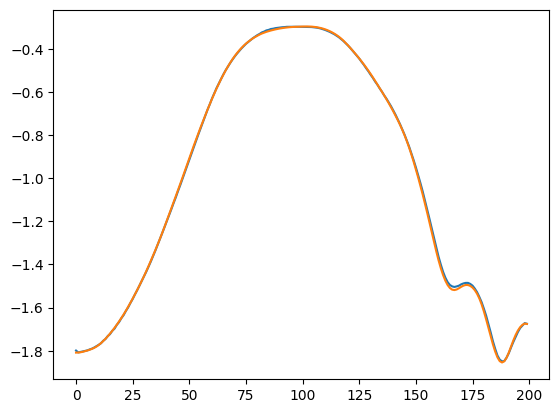

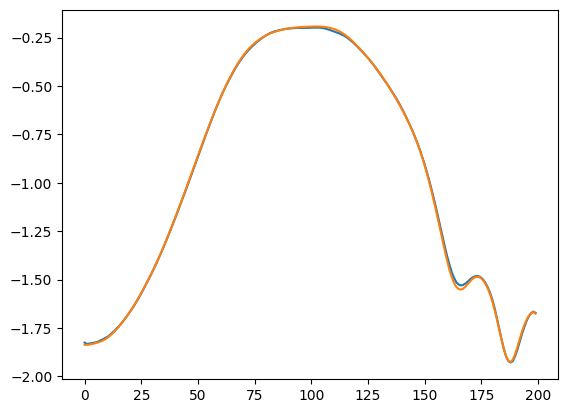

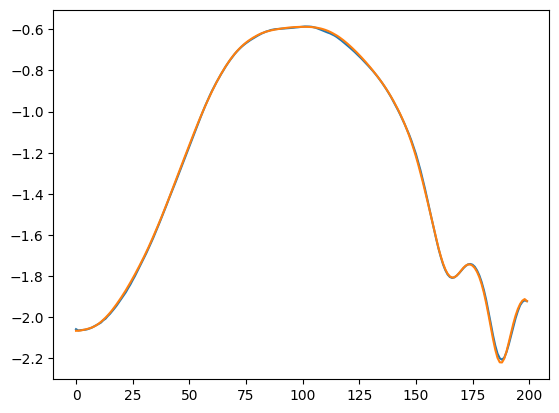

In [7]:

h_eff_reconstruction=ifft(h_eff_fft_reconstruction[:,0]+1j*h_eff_fft_reconstruction[:,1],norm='forward',axis=1)


h_eff=ifft(h_eff_fft[:,0]+1j*h_eff_fft[:,1],norm='forward',axis=1)



for i in range(h_eff.shape[-1]):
    plt.plot(h_eff_reconstruction[idx,:,i])
   # plt.plot(h_eff_reconstruction_filter[idx,:,i])
    plt.plot(h_eff[idx,:,i])
    plt.show()
    



#### (Optional) Reconstruction filter

In [ ]:

for i in range(h_eff.shape[-1]):
    #plt.plot(h_eff_reconstruction[idx,:,i])
    plt.plot(h_eff_reconstruction_filter[idx,:,i])
    plt.plot(h_eff[idx,:,i])
    plt.show()
    

## DL-effective field and computation via auxiliary system

#### Imports

In [8]:
import torch
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
from typing import List
from src.tddft_methods.field2field_utils import field2field_mapping

#### Data

In [9]:
data = np.load(
    "data/dataset_h_eff/periodic/dataset_periodic_random_rate_0-1_nbatch_100_batchsize_1000_steps_200_tf_20.0_l_8_240229.npz"
)

maxdata=100

h = data["h"][-maxdata:]
h_eff = data["h_eff"][-maxdata:]
z=data['z'][-maxdata:]

# Loading the model
model = torch.load(
    "model_rep/kohm_sham/cnn_field2field/REDENT2D_fourier_field2field_time_steps_200_tf_20_240327_dataset_60k_[80, 80, 80]_hc_[15, 5]_ks_1_ps_3_nconv_1_nblock",
    map_location="cpu",
)
model.eval()

REDENT2D(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv2d(2, 80, kernel_size=(15, 5), stride=(1, 1), padding=(7, 2), padding_mode=circular)
      (batch_norm 1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation 1): GELU(approximate='none')
      (conv_1_1): Conv2d(80, 80, kernel_size=(15, 5), stride=(1, 1), padding=(7, 2), padding_mode=circular)
      (batch_norm 1_1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_1_1): GELU(approximate='none')
      (pooling 1): AvgPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0)
    )
    (1): Sequential(
      (conv2): Conv2d(80, 80, kernel_size=(15, 5), stride=(1, 1), padding=(7, 2), padding_mode=circular)
      (activation 2): GELU(approximate='none')
      (conv_2_1): Conv2d(80, 80, kernel_size=(15, 5), stride=(1, 1), padding=(7, 2), padding_mode=circular)
      (activation_2_1): GELU(approximate='none')
      (pool

#### $h_{eff}(t)$ from the DL mapping

In [10]:
h_eff_prediction=field2field_mapping(model=model,h_input=h)


(100, 2, 200, 8)
torch.Size([100, 2, 101, 8])


#### Check the comparison with the exact $h_{eff}(t)$

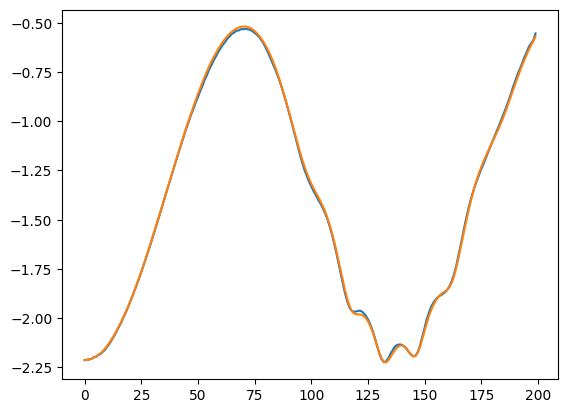

In [11]:
index_sample=np.random.randint(0,maxdata)

idx=4
plt.plot(h_eff_prediction[index_sample,:,idx])
plt.plot(h_eff[index_sample, :, idx])
plt.show()

#### Build up the effective dynamics VIA Qutip

Imports

In [33]:
from tqdm import trange, tqdm
from src.training.models_adiabatic import EnergyReductionXXZ
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from src.tddft_methods.kohm_sham_utils import (
    initialize_psi_from_z,
    nonlinear_schrodinger_step_zzx_model_full_effective_field,
    get_effective_field,
)
import qutip


class Driving:
    def __init__(self, h: np.array, idx: int, dt: float) -> None:
        self.h = h
        # self.tf=tf
        self.idx: int = idx
        self.dt: float = dt

    def field(self, t: float, args):
        if int(t / self.dt) == self.h.shape[0]-1:
            return self.h[-1, self.idx]
        else:
            return self.h[int(t / self.dt), self.idx]

    def get_the_field(
        self,
    ):
        return self.h

Initialization

In [34]:
l = 8
steps = 200
tf = 20.0
time = np.linspace(0.0, tf, steps)
dt = time[1] - time[0]
print(dt)

ham0 = SpinOperator(index=[("x", i) for i in range(l)], coupling=[1] * l, size=l)


# %% Compute the initial ground state configuration


for idx in range(l):
    psi0 = np.zeros(2)
    psi0[0] = np.sqrt((1 + z[index_sample, 0, idx]) / 2)
    psi0[1] = np.sqrt((1 - z[index_sample, 0, idx]) / 2)
    
    if idx==0:
        psi=psi0
    else:
        psi=np.kron(psi,psi0)
        
psi0 = qutip.Qobj(
    psi, shape=psi.shape, dims=([[2 for i in range(l)],[1]])
)



# Measure observable
obs:List=[]
for i in range(l):
    obs.append(SpinOperator(index=[("z", i)], coupling=[1], size=l).qutip_op)

print(obs[0],len(obs))

print("\n INITIALIZE THE HAMILTONIAN \n")
# build up the time dependent object for the qutip evolution
hamiltonian = [ham0.qutip_op]
print(h_eff_prediction.shape)
for i in range(l):
    drive_z = Driving(
        h=
            h_eff_prediction[index_sample]
        ,
        idx=i,
        dt=time[1] - time[0],
    )

    hamiltonian.append([obs[i], drive_z.field])

# evolution
output = qutip.sesolve(
    hamiltonian,
    psi0,
    time,
    e_ops=obs
)

z_prediction=np.zeros((time.shape[0],l))
for r in range(l):
    z_prediction[:, r] = output.expect[r]

0.10050251256281408
Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2]], shape = (256, 256), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]] 8

 INITIALIZE THE HAMILTONIAN 

(100, 200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(200, 8)
(2